In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datasets import CIFAR_simclr

In [1]:
dataset= "cifar10"
run= "latest-weights"
n_epochs= 1000
radiuses= [0.63, 0.75, 0.9]


In [11]:
if dataset=="cifar10" or dataset=="cifar100":
    dataset_train= CIFAR_simclr(dataset, n_epochs, train=True)
    dataset_test= CIFAR_simclr(dataset, n_epochs, train=False)
    eval_freq = np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                               np.repeat(50, 20), np.repeat(100,40),
                                np.repeat(200,20), np.repeat(500, 10)))
    if dataset=="cifar100":
        eval_freq= np.concatenate((eval_freq, np.repeat(500, 20)))
    idx= np.cumsum(eval_freq)


In [12]:
def get_scores(algorithm, run, dataset, n_epochs, rad, sd):
    if algorithm=="random" or algorithm=="full":
        rad=0.0
    run_path= f"/Users/victoriabarenne/{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    if algorithm=="full":
        scores= pd.read_csv(run_path +"full.csv", index_col=0)["full_scores"].to_numpy()
    else:
        scores= pd.read_csv(run_path +f"{algorithm}_scores.csv", index_col=0)[f"{algorithm}_scores"].to_numpy()

    return scores.reshape(-1,1)

def get_queries(algorithm, run, dataset, n_epochs, rad, sd):
    if algorithm=="random" or algorithm=="full":
        rad=0.0
    run_path= f"/Users/victoriabarenne/{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    queries= pd.read_csv(run_path +f"{algorithm}_queries.csv", index_col=0)[f"{algorithm}_queries"].to_numpy()
    return queries.reshape(-1,1)

def get_degrees(algorithm, run, dataset, n_epochs, rad, sd):
    assert(algorithm=="pc" or algorithm=="adpc")
    run_path= f"/Users/victoriabarenne/{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    df= pd.read_csv(run_path +f"{algorithm}_degrees.csv", index_col=0)
    degrees= df[f"{algorithm}_degrees"].to_numpy()
    options=df[f"{algorithm}_options"].to_numpy()
    return degrees.reshape(-1,1), options.reshape(-1,1)

def get_transition(algorithm, run, dataset, n_epochs, rad, sd):
    assert(algorithm=="pc" or algorithm=="adpc")
    run_path= f"/Users/victoriabarenne/{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    df= pd.read_csv(run_path +f"{algorithm}_degrees.csv", index_col=0)
    degrees= df[f"{algorithm}_degrees"].to_numpy()
    options=df[f"{algorithm}_options"].to_numpy()
    if algorithm=="pc":
        id_min= np.where(degrees==0)[0]
        id_max= None
    if algorithm=="adpc":
        id_min= np.where(degrees==0)[0]
        id_max= np.where(degrees>0)[0][-1]
    return id_min, id_max

def get_radiuses(algorithm, run, dataset, n_epochs, rad, sd):
    assert(algorithm=="pc" or algorithm=="adpc")
    run_path= f"/Users/victoriabarenne/{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    radiuses= np.load(run_path+f"{algorithm}_radiuses.npy")
    return radiuses

def get_covers(algorithm, run, dataset, n_epochs, rad, sd):
    assert(algorithm=="pc" or algorithm=="adpc")
    run_path= f"/Users/victoriabarenne/{run}/{dataset}/{n_epochs}_4_{rad}_{sd}/"
    covers= pd.read_csv(run_path+f"{algorithm}_covers.csv", index_col=0)[f"{algorithm}_covers"].to_numpy()
    return covers.reshape(-1,1)



In [13]:
def plot_degrees(run, dataset, n_epochs, rad, type, sd):
    # Get points for the x axis
    eval_freq = np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                    np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                                   np.repeat(50, 20), np.repeat(100,40),
                                    np.repeat(200,20), np.repeat(500, 10)))
    if dataset=="cifar100":
        eval_freq= np.concatenate((eval_freq, np.repeat(500, 20)))
    idx= np.cumsum(eval_freq)
    idx= np.arange(1, idx.max()+1)

    # Get the scores
    adpc_deg, adpc_options= get_degrees("adpc", run, dataset, n_epochs, rad, sd=sd)
    pc_deg, pc_options= get_degrees("pc", run, dataset, n_epochs, 0.0, sd=sd)
    m= len(adpc_deg)
    idx, adpc_deg, adpc_options, pc_deg, pc_options= idx[:m], adpc_deg[:m], adpc_options[:m], pc_deg[:m], pc_options[:m]

    if m< len(idx):
        print(f"Run not fully completed, current number of queries for the run is {idx[m-1]}")

    if type=="degrees":
        plt.plot(idx, adpc_deg, color= "green", label= "Adaptive PC")
        plt.plot(idx, pc_deg, color= "blue", label= "PC")
        plt.title(label= "Number of degrees of the selected query")
    if type=="options":
        plt.plot(idx, adpc_options, color= "green", label= "Adaptive PC")
        plt.plot(idx, pc_options, color= "blue", label= "PC")
        plt.title(label= "Number of options for queries with the same out-degree")
    plt.legend()
    plt.show()

In [14]:
def plot_scores(run, dataset, n_epochs, rad, n_seeds, axis, relative= False):
    # Get points for the x axis
    eval_freq = np.concatenate((np.repeat(1, 100), np.repeat(2, 50),
                                    np.repeat(5, 20), np.repeat(10, 20), np.repeat(20, 25),
                                   np.repeat(50, 20), np.repeat(100,40),
                                    np.repeat(200,20), np.repeat(500, 10)))
    if dataset=="cifar100":
        eval_freq= np.concatenate((eval_freq, np.repeat(500, 20)))
    idx= np.cumsum(eval_freq)
    n_eval= len(idx)

    # Get the scores
    pc_scores, random_scores = np.zeros(shape= (n_eval, 0)), np.zeros(shape= (n_eval, 0))
    for sd in np.arange(1, n_seeds+1):
        pc_scores = np.concatenate((pc_scores, get_scores("pc", run, dataset, n_epochs, 0.0, sd)[:n_eval]), axis=1)
        random_scores = np.concatenate((random_scores, get_scores("random", run, dataset, n_epochs, rad, sd)[:n_eval]), axis=1)
    full_scores = get_scores("full", run, dataset, n_epochs, 0.0, sd)[:n_eval]
    min_length= n_eval
    for sd in np.arange(1, n_seeds+1):
        adpc_scores = get_scores("adpc", run, dataset, n_epochs, rad, sd)
        if len(adpc_scores)<min_length:
            min_length= len(adpc_scores)
    adpc_scores= np.zeros(shape=(min_length, 0))
    for sd in np.arange(1, n_seeds+1):
        adpc_scores = np.concatenate((adpc_scores, get_scores("adpc", run, dataset, n_epochs, rad, sd)[:min_length]), axis=1)

    pc_mean, pc_std = pc_scores.mean(1), pc_scores.std(1)
    random_mean, random_std = random_scores.mean(1), random_scores.std(1)
    adpc_mean, adpc_std = adpc_scores.mean(1), adpc_scores.std(1)
    full_scores= full_scores.squeeze()
    m= len(adpc_mean)
    if m< n_eval:
        print(f"Run not fully completed, current number of queries for the run is {idx[m-1]}")

    if relative:
        pc_mean, random_mean, adpc_mean = pc_mean[:m]-full_scores[:m], random_mean[:m]-full_scores[:m],\
                                          adpc_mean-full_scores[:m]
    else:
        pc_mean, random_mean, adpc_mean = pc_mean[:m], random_mean[:m], adpc_mean
    pc_std, random_std = pc_std[:m], random_std[:m]
    idx = idx[:m]


    axis.plot(idx, random_mean, color= "green", label= "Random")
    axis.fill_between(idx, random_mean-random_std, random_mean+random_std, alpha=0.5, color= "green")

    axis.plot(idx, pc_mean, color= "blue", label= "PC")
    axis.fill_between(idx, pc_mean-pc_std, pc_mean+pc_std, alpha=0.5, color= "blue")

    axis.plot(idx, adpc_mean, color= "red", label= "Adaptive PC")
    axis.fill_between(idx, adpc_mean-adpc_std, adpc_mean+adpc_std, alpha=0.5, color= "red")
    if not relative:
        axis.plot(idx, full_scores[:m], label= "Oracle")


In [15]:
def plot_radiuses_metrics(run, dataset, n_epochs, rad, n_seeds, axis):
    radiuses= np.empty(shape=(50000, len(idx), n_seeds))
    for sd in np.arange(1, n_seeds+1):
        radiuses[:,:,sd-1]= get_radiuses("adpc", run, dataset, n_epochs, rad, sd)
    axis.plot(idx, radiuses.mean(axis=0).mean(axis=1), label="mean")
    axis.fill_between(idx, radiuses.mean(axis=0).mean(axis=1)+radiuses.mean(axis=0).std(axis=1),
                     radiuses.mean(axis=0).mean(axis=1)-radiuses.mean(axis=0).std(axis=1), alpha=0.5)
    axis.plot(idx, radiuses.min(axis=0).mean(axis=1), label= "min")
    axis.fill_between(idx, radiuses.min(axis=0).mean(axis=1)+radiuses.min(axis=0).std(axis=1),
                     radiuses.min(axis=0).mean(axis=1)-radiuses.min(axis=0).std(axis=1), alpha=0.5)
    axis.plot(idx, radiuses.max(axis=0).mean(axis=1), label= "max")
    axis.fill_between(idx, radiuses.max(axis=0).mean(axis=1)+radiuses.max(axis=0).std(axis=1),
                     radiuses.max(axis=0).mean(axis=1)-radiuses.max(axis=0).std(axis=1), alpha=0.5)


In [16]:
def plot_covers(run, dataset, n_epochs, rad, n_seeds, axis):
    covers_adpc, covers_pc= np.empty(shape=(len(idx), n_seeds)), np.empty(shape=(len(idx), n_seeds))
    for sd in np.arange(1, n_seeds+1):
        covers_adpc[:, sd-1]= get_covers("adpc", run, dataset, n_epochs, rad, sd).squeeze()
        covers_pc[:, sd-1]= get_covers("pc", run, dataset, n_epochs, 0.0, sd).squeeze()
    axis.plot(idx, covers_adpc.mean(axis=1), label="Adaptive PC", color= "red")
    axis.fill_between(idx, covers_adpc.mean(axis=1)+covers_adpc.std(axis=1),
                     covers_adpc.mean(axis=1)-covers_adpc.std(axis=1), alpha=0.5, color= "red")
    axis.plot(idx, covers_pc.mean(axis=1), label="PC", color= "blue")
    axis.fill_between(idx, covers_pc.mean(axis=1)+covers_pc.std(axis=1),
                     covers_pc.mean(axis=1)-covers_pc.std(axis=1), alpha=0.5, color= "blue")


## Sanity Check: ProbCover with radius 0.75

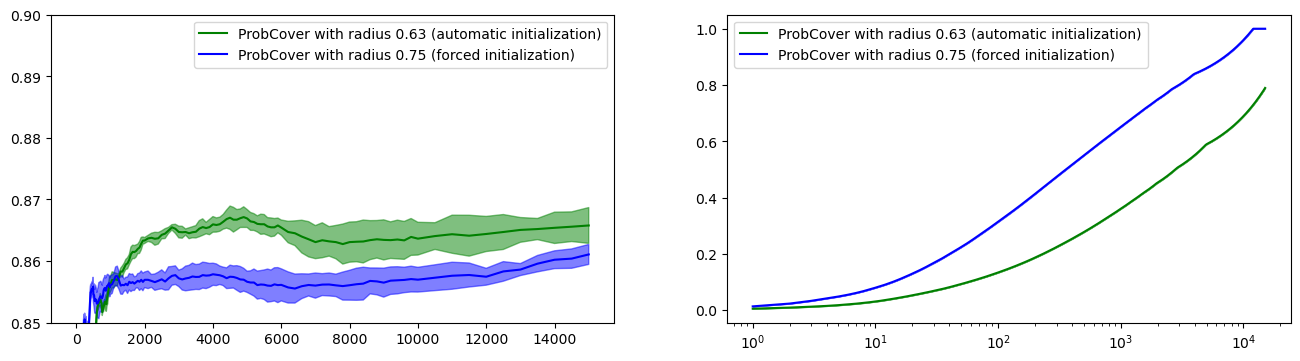

In [51]:
run= "thesis_experiments/latest"

n_seeds=5
n_eval= len(idx)
# Get the scores
pc_scores, pc_scores_check = np.zeros(shape= (n_eval, 0)), np.zeros(shape= (n_eval, 0))
pc_covers, pc_covers_check= np.empty(shape=(len(idx), n_seeds)), np.empty(shape=(len(idx), n_seeds))
    
for sd in np.arange(1, n_seeds+1):
    pc_scores = np.concatenate((pc_scores, get_scores("pc", run, dataset, n_epochs, 0.0, sd)[:n_eval]), axis=1)
    pc_scores_check = np.concatenate((pc_scores_check, get_scores("pc", run, dataset, n_epochs, 0.75, sd)[:n_eval]), axis=1)

for sd in np.arange(1, n_seeds+1):
        pc_covers[:, sd-1]= get_covers("pc", run, dataset, n_epochs, 0.0, sd).squeeze()
        pc_covers_check[:, sd-1]= get_covers("pc", run, dataset, n_epochs, 0.75, sd).squeeze()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
# ax1.set_xscale("log")
# ax1.set_xlim(1000,15000)
ax1.set_ylim(0.85, 0.9)

ax2.set_xscale("log")

ax1.plot(idx, pc_scores.mean(1), color= "green", label= "ProbCover with radius 0.63 (automatic initialization)")
ax1.fill_between(idx, pc_scores.mean(1)-pc_scores.std(1), pc_scores.mean(1)+pc_scores.std(1), alpha=0.5, color= "green")

ax1.plot(idx, pc_scores_check.mean(1), color= "blue", label= "ProbCover with radius 0.75 (forced initialization)")
ax1.fill_between(idx, pc_scores_check.mean(1)-pc_scores_check.std(1), pc_scores_check.mean(1)+pc_scores_check.std(1), alpha=0.5, color= "blue")
ax1.legend()

ax2.plot(idx, pc_covers.mean(1), color= "green", label= "ProbCover with radius 0.63 (automatic initialization)")
ax2.fill_between(idx, pc_covers.mean(1)-pc_covers.std(1), pc_covers.mean(1)+pc_covers.std(1), alpha=0.5, color= "green")

ax2.plot(idx, pc_covers_check.mean(1), color= "blue", label= "ProbCover with radius 0.75 (forced initialization)")
ax2.fill_between(idx, pc_covers_check.mean(1)-pc_covers_check.std(1), pc_covers_check.mean(1)+pc_covers_check.std(1), alpha=0.5, color= "blue")
ax2.legend()

plt.show()


## Checking scores, radiuses and cover

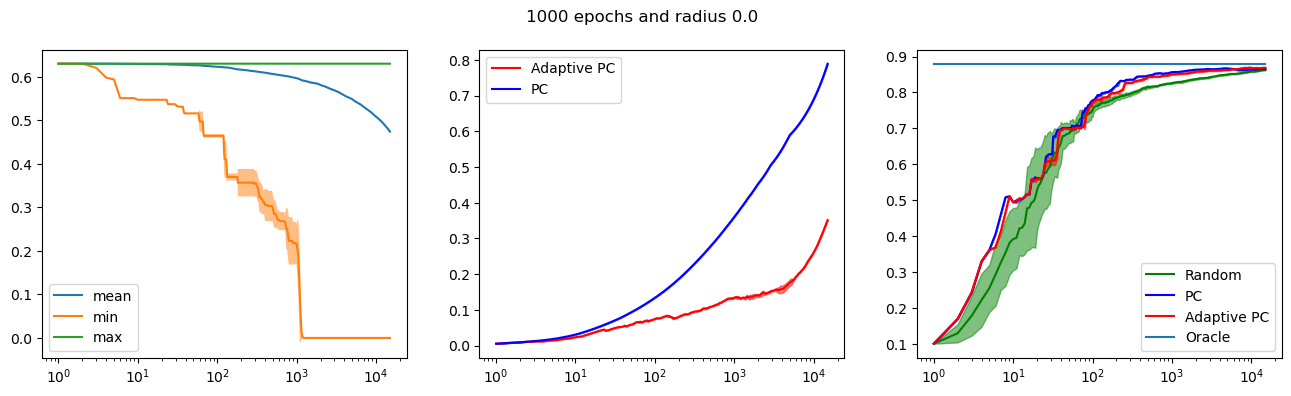

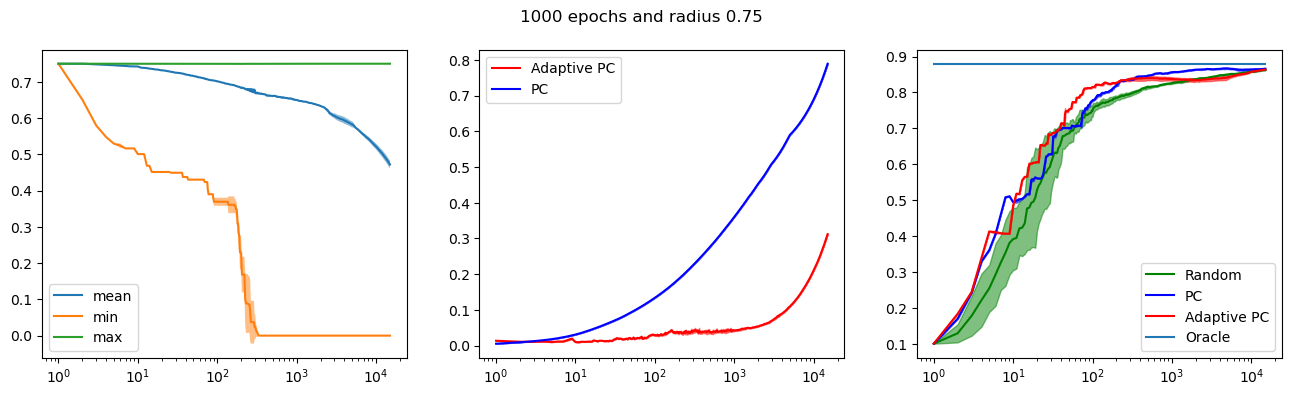

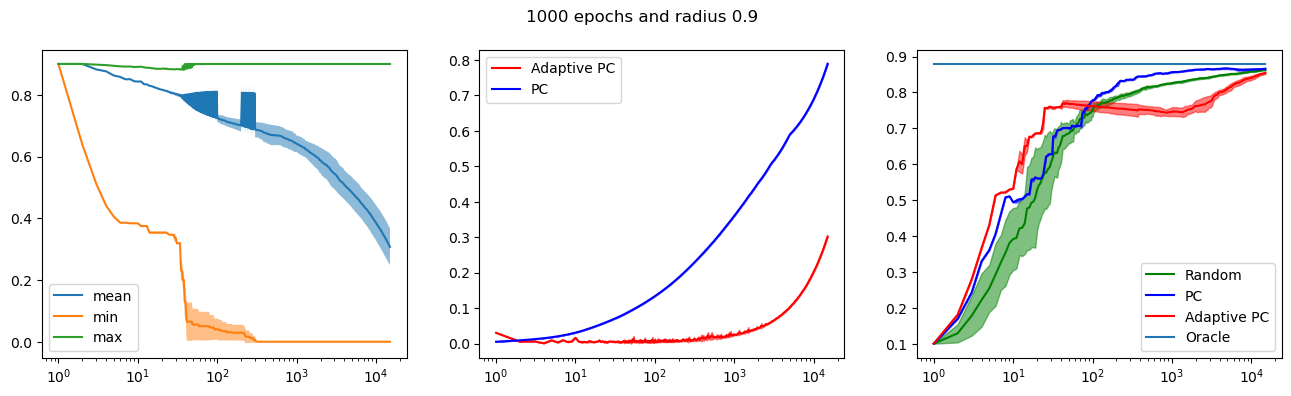

In [32]:
run= "latest-weights"
dataset= "cifar10"
n_epochs= 1000
rads= [0.0, 0.75, 0.9]
n_seeds= 5
relative= False


for rad in rads:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    ax1.set_xscale("log")
    ax2.set_xscale("log")
    ax3.set_xscale("log")

    plot_radiuses_metrics(run, dataset, n_epochs, rad, n_seeds, ax1)
    plot_covers(run, dataset, n_epochs, rad, n_seeds, ax2)
    plot_scores(run, dataset, n_epochs, rad, n_seeds=5, relative=relative, axis=ax3)
    ax1.legend()
    ax2.legend()
    ax3.legend()
    fig.suptitle(f"{n_epochs} epochs and radius {rad}")
    plt.show()


There is an odd behaviour in the radius 0.9 plot: The max radius seems to increase. That's because from the 3rd query max is around 0.87 and then it increases back to its usual value. It's explainted by the fact that the minimum radius after two queries is alreay as low as 0.63, since this point will be included as a neighbour for all queries, then the max radius for query 3 is at around 0.87.

The dip in minimum radius? Getting stuck in a region

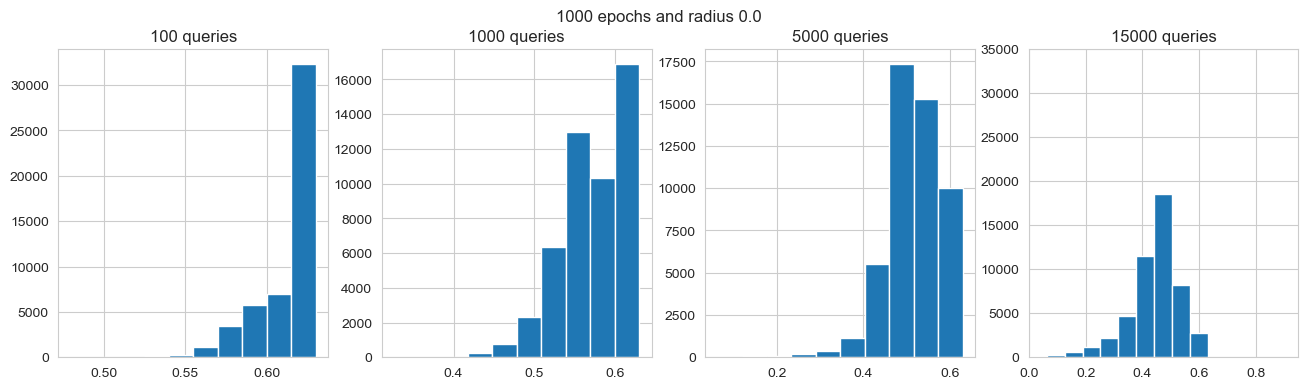

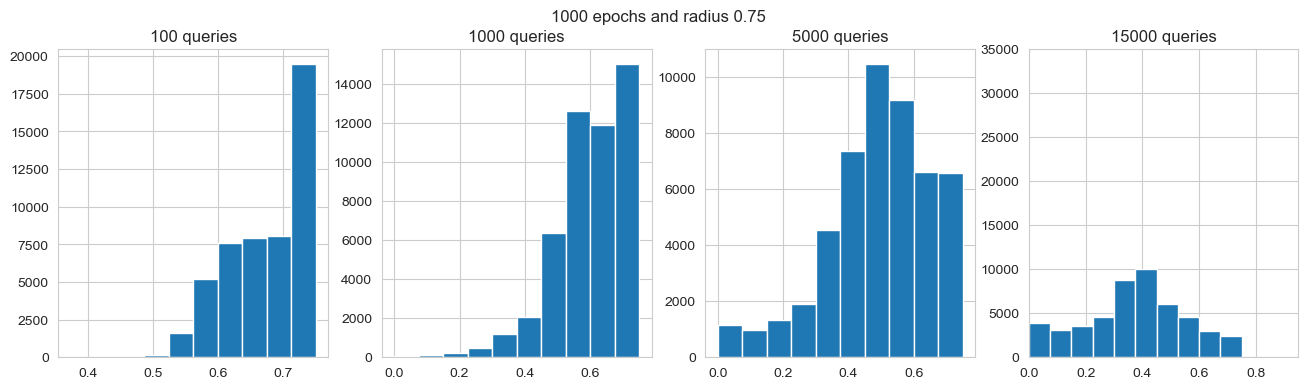

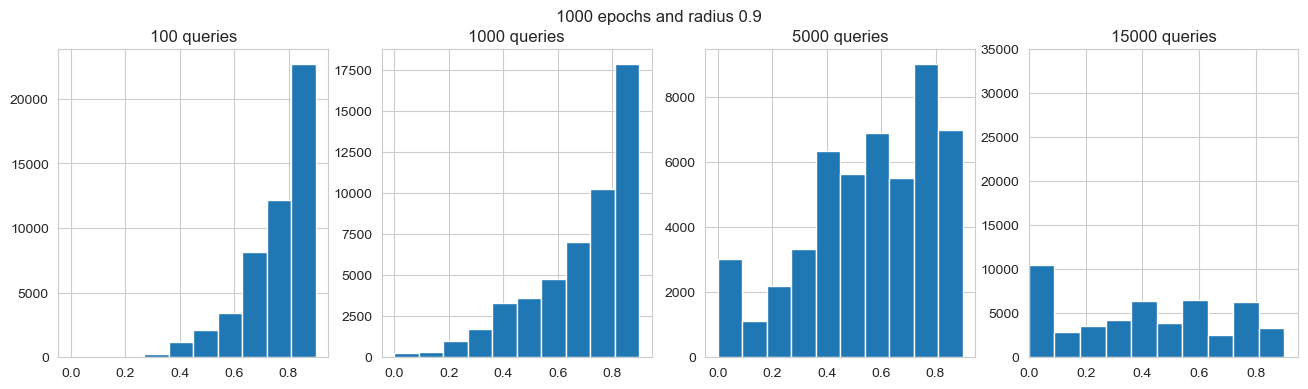

In [47]:
run= "latest"
dataset= "cifar10"
n_epochs= 1000
rads= [0.0, 0.75, 0.9]
n_seeds= 4
# for number of queries [100, 120, 150, 200, 1000, 5000, 10000, 50000]
# eval_idx= [99, 109, 124, 149, 214, 264, 294, 304]
eval_idx= [99, 214, 264, 304]
for rad in rads:
    radiuses= np.empty(shape=(50000, len(idx), n_seeds))
    for sd in np.arange(1, n_seeds+1):
        radiuses[:,:,sd-1]= get_radiuses("adpc", run, dataset, n_epochs, rad, sd)
    radiuses= radiuses.mean(axis=2)
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    j=0
    for i in eval_idx:
        axs[j].hist(radiuses[:,i], density= False)
        axs[j].title.set_text(f"{idx[i]} queries")
        plt.xlim(0,0.95)
        plt.ylim(0,35000)
        j+=1
    plt.suptitle(f"{n_epochs} epochs and radius {rad}")
    plt.show()


## Checking radius updating: weights

In [48]:
from datasets import CIFAR_simclr
import faiss
dataset= "cifar10"
n_epochs= 1000
dataset_train= CIFAR_simclr(dataset= dataset, n_epochs= n_epochs, train=True)
# dataset_test= CIFAR_simclr(dataset= dataset, n_epochs= n_epochs, train=False)


Reminder: we find the K nearest labeled neighbours (K=5 here) 

0.21844998882935027
0.18537148924501415
0.16965101910489305
0.1699226496031492


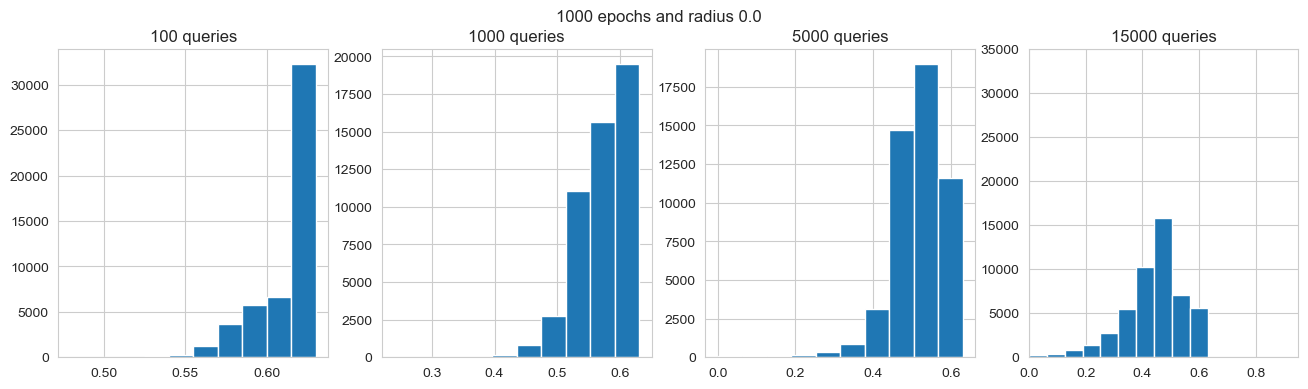

0.2755625371322564
0.17538388822238402
0.18097542859079124
0.19337563683138445


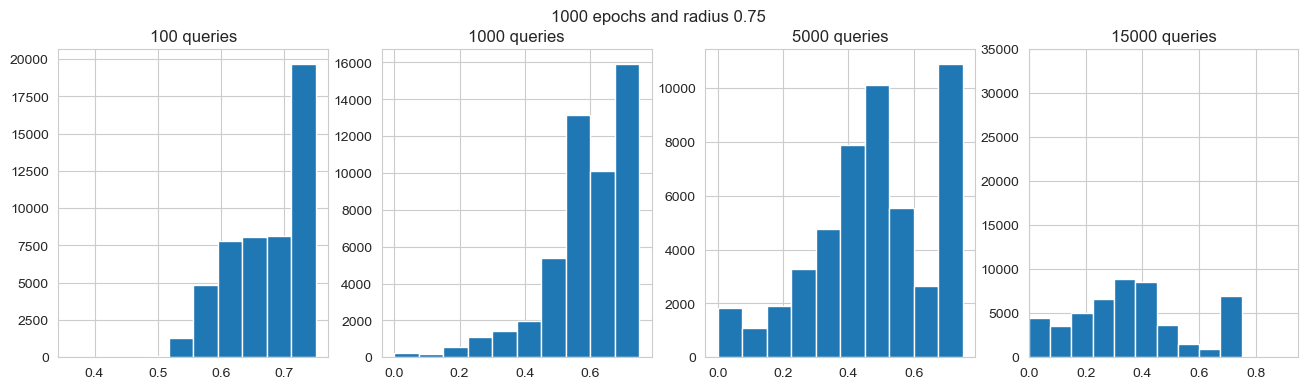

0.18599317372767354
0.1693223474502183
0.16826341245643114
0.16844955043812132


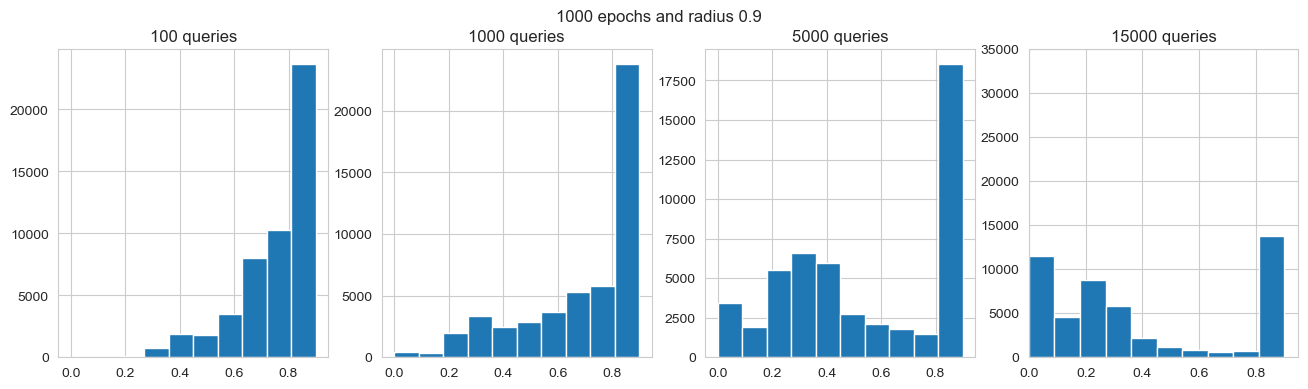

In [49]:
run="latest"
n_epochs=1000
dataset= "cifar10"
radiuses= [0.0, 0.75, 0.9]
eval_idx= [99, 214, 264, 304]
deg=8
n_seeds= 1


for rad in radiuses:
    j=0
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for i in eval_idx:
        alphas= np.empty(shape= (50000-idx[i], n_seeds))
        for sd in range(1, n_seeds+1):
            dataset_train.restart()
            queries= get_queries("adpc", run, dataset, n_epochs, rad, sd)
            radiuses= get_radiuses("adpc", run, dataset, n_epochs, rad, sd)
            dataset_train.observe(queries[:idx[i]].squeeze())
            dataset_train.radiuses= radiuses[:,i]
            index_knn = faiss.IndexFlatL2(dataset_train.d)  # build the index
            index_knn.add(dataset_train.x[dataset_train.queries].astype("float32"))  # fit it to the labeled data
            n_neighbours = 5 
            D_neighbours, I_neighbours = index_knn.search(dataset_train.x[dataset_train.labeled == 0].astype("float32"), n_neighbours)  # find K-nn for all
            new_radiuses = dataset_train.radiuses.copy()
            D_neighbours= np.sqrt(D_neighbours)

            gauss_distances = np.exp(-D_neighbours ** deg / new_radiuses[dataset_train.labeled == 0].reshape(-1, 1) ** deg)
            # gauss_distances2= np.exp(-D_neighbours ** deg / (new_radiuses[dataset_train.labeled == 0].reshape(-1, 1) ** deg))
            # gauss_distances3= np.exp(-(D_neighbours / new_radiuses[dataset_train.labeled == 0].reshape(-1, 1))** deg)
            norm = (gauss_distances.sum(axis=1, keepdims=True) + 1)
            alpha = (1 / norm)[:, 0] #squeezing
            weights = gauss_distances / norm
            alphas[:, sd-1]= alpha.squeeze()
        alphas= alphas.mean(axis=1)
        print(alphas.min())
        axs[j].hist(radiuses[:,i], density= False)
        axs[j].title.set_text(f"{idx[i]} queries")
        plt.xlim(0,0.95)
        plt.ylim(0,35000)
        j+=1
    plt.suptitle(f"{n_epochs} epochs and radius {rad}")
    plt.show()



    

Idea: The weight of a point for itself would be at least 1/6= 0.1666 for K=5. So the radius cannot be pushed to 0 by the weighing alone. It is due to reducing the intersections. Previously, was running that we reduce the radius to pessimistic_radius= min(r, d/2), where d is the distance between one neighbour of different label. Currently still running reduction to min(r, d) for extreme cases.
+ Will try maybe 0.75*d or other weights 
+ set a minimum radius
+ try the max(optimistic, pessimistic): to allow bigger intersections


## Checking average distance of new query to labeled points

In [50]:
from datasets import CIFAR_simclr
import faiss
dataset= "cifar10"
n_epochs= 1000
dataset_train= CIFAR_simclr(dataset= dataset, n_epochs= n_epochs, train=True)
# dataset_test= CIFAR_simclr(dataset= dataset, n_epochs= n_epochs, train=False)


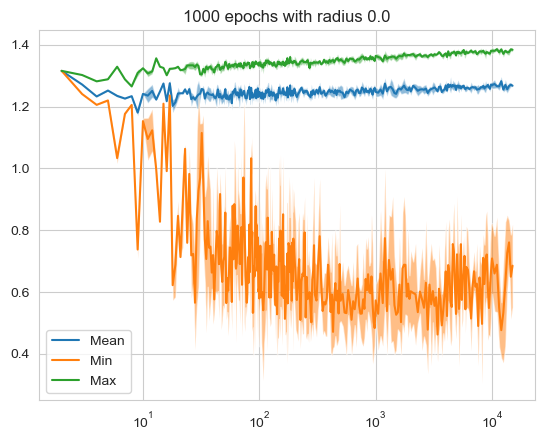

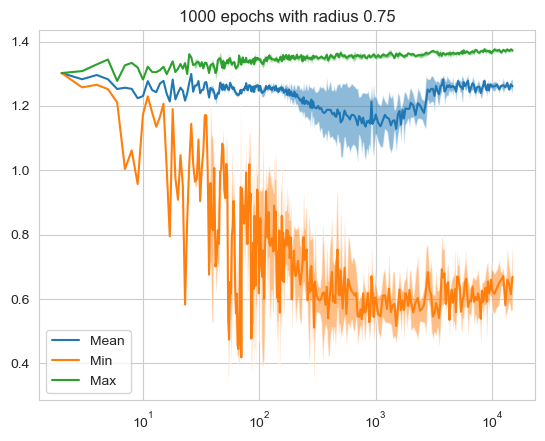

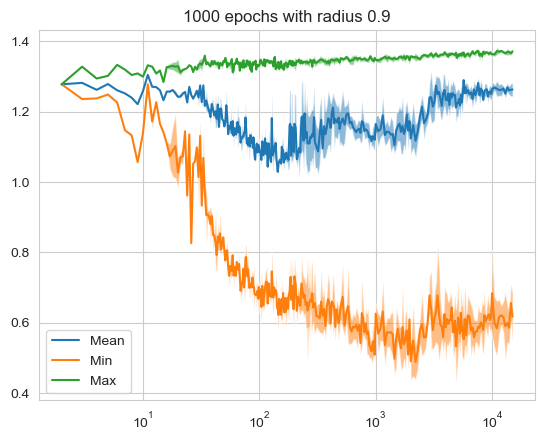

In [51]:
run="latest"
n_epochs=1000
sd= 1
dataset= "cifar10"
radiuses= [0.0, 0.75, 0.9]
eval_idx= 99
n_seeds=5

#get the average distance of new_query to other labeled points
for rad in radiuses:
    max_all, min_all, mean_all= np.empty(shape=(304, n_seeds)), np.empty(shape=(304, n_seeds)), np.empty(shape=(304, n_seeds))
    for sd in range(1, n_seeds+1):
        queries= get_queries("adpc", run, dataset, n_epochs, rad, sd)
        max, min, mean = [], [], []
        for eval_idx in np.arange(n_eval-1):
            dataset_train.restart()
            dataset_train.observe(queries[:idx[eval_idx]].squeeze())
            new_query_id= queries[idx[eval_idx]]

            dist_to_labeled = np.linalg.norm(dataset_train.x[new_query_id, :] - dataset_train.x[dataset_train.queries, :], axis=1)
            max.append(dist_to_labeled.max())
            min.append(dist_to_labeled.min())
            mean.append(dist_to_labeled.mean())
        max_all[:,sd-1], min_all[:, sd-1], mean_all[:, sd-1]= max, min, mean

    plt.plot(idx[1:], mean_all.mean(1), label= "Mean")
    plt.fill_between(idx[1:],  mean_all.mean(1)- mean_all.std(1),  mean_all.mean(1)+ mean_all.std(1), alpha=0.5)

    plt.plot(idx[1:], min_all.mean(1), label= "Min")
    plt.fill_between(idx[1:],  min_all.mean(1)- min_all.std(1),  min_all.mean(1)+ min_all.std(1), alpha=0.5)

    plt.plot(idx[1:], max_all.mean(1), label= "Max")
    plt.fill_between(idx[1:],  max_all.mean(1)- max_all.std(1),  max_all.mean(1)+ max_all.std(1), alpha=0.5)

    plt.legend()
    plt.title(label= f"{n_epochs} epochs with radius {rad}")
    plt.xscale("log")
    plt.show()


Distance to last sampled point. Mean goes down: we sample in the same region

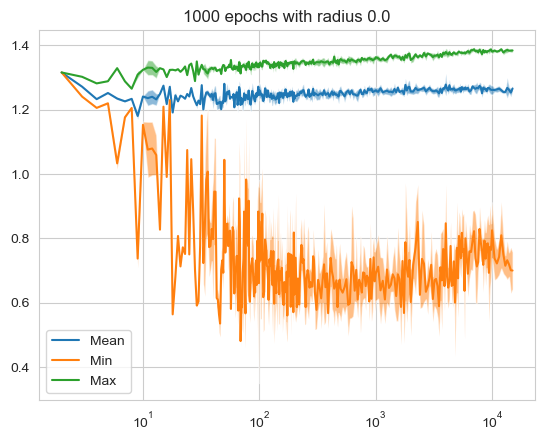

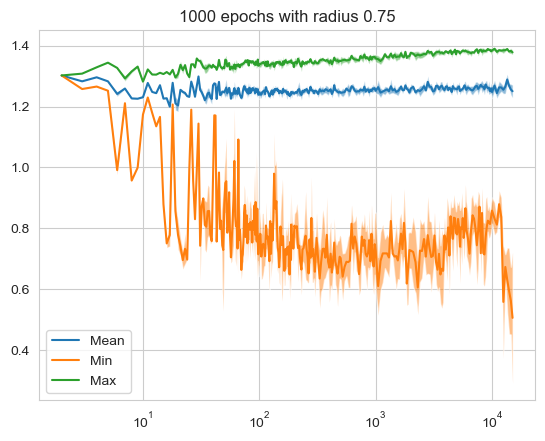

In [52]:
run="latest"
n_epochs=1000
sd= 1
dataset= "cifar10"
radiuses= [0.0, 0.75]
eval_idx= 99
n_seeds=5

#get the average distance of new_query to other labeled points
for rad in radiuses:
    max_all, min_all, mean_all= np.empty(shape=(304, n_seeds)), np.empty(shape=(304, n_seeds)), np.empty(shape=(304, n_seeds))
    for sd in range(1, n_seeds+1):
        queries= get_queries("pc", run, dataset, n_epochs, rad, sd)
        max, min, mean = [], [], []
        for eval_idx in np.arange(n_eval-1):
            dataset_train.restart()
            dataset_train.observe(queries[:idx[eval_idx]].squeeze())
            new_query_id= queries[idx[eval_idx]]

            dist_to_labeled = np.linalg.norm(dataset_train.x[new_query_id, :] - dataset_train.x[dataset_train.queries, :], axis=1)
            max.append(dist_to_labeled.max())
            min.append(dist_to_labeled.min())
            mean.append(dist_to_labeled.mean())
        max_all[:,sd-1], min_all[:, sd-1], mean_all[:, sd-1]= max, min, mean

    plt.plot(idx[1:], mean_all.mean(1), label= "Mean")
    plt.fill_between(idx[1:],  mean_all.mean(1)- mean_all.std(1),  mean_all.mean(1)+ mean_all.std(1), alpha=0.5)

    plt.plot(idx[1:], min_all.mean(1), label= "Min")
    plt.fill_between(idx[1:],  min_all.mean(1)- min_all.std(1),  min_all.mean(1)+ min_all.std(1), alpha=0.5)

    plt.plot(idx[1:], max_all.mean(1), label= "Max")
    plt.fill_between(idx[1:],  max_all.mean(1)- max_all.std(1),  max_all.mean(1)+ max_all.std(1), alpha=0.5)

    plt.legend()
    plt.title(label= f"{n_epochs} epochs with radius {rad}")
    plt.xscale("log")
    plt.show()


## Checking randomness in selecting a new query

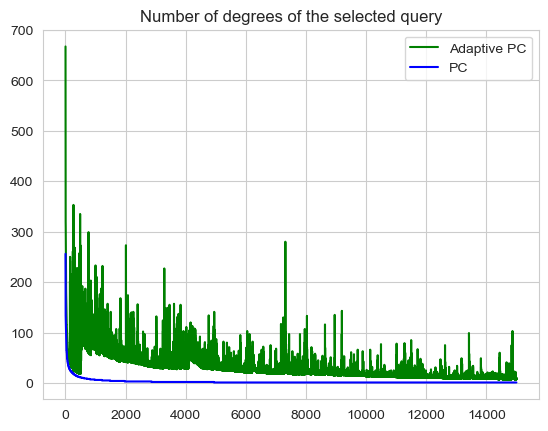

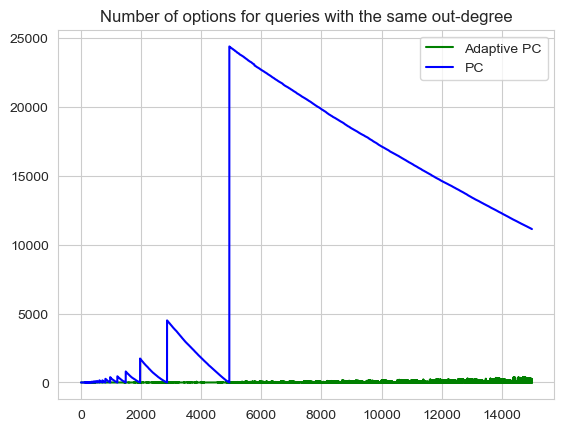

In [53]:
run= "latest"
dataset= "cifar10"
rad= 0.75
n_epochs=1000
sd=2
plot_degrees(run, dataset, n_epochs, rad, "degrees", sd)
plot_degrees(run, dataset, n_epochs, rad, "options", sd)